In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
data_import = files.upload()

Saving final_song_set.csv to final_song_set.csv


In [ ]:
raw_songs = pd.read_csv('final_song_set.csv').drop(columns= 'Unnamed: 0').rename(columns={"top genre": "genre", "pop": "popularity"})
raw_songs

,Mason_Like,Mary_Like,title,artist,genre,year,added,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,popularity
0,0,1,Snake Eyes,Feint,dance,2012,1969‑12‑31,174,82,50,-6,26,18,265,0,7,60
1,0,1,Blame,Egypt Central,alternative metal,2011,1969‑12‑31,168,92,40,-5,5,42,199,0,17,25
2,0,1,rap music,Lil Darkie,rap,2020,1969‑12‑31,127,96,58,1,7,72,197,29,36,67
3,0,1,spy?,WHOKILLEDXIX,pop,2020,1969‑12‑31,100,56,87,-5,10,65,154,6,6,75
4,0,1,North Memphis,Pharmacist,aesthetic rap,2019,1969‑12‑31,167,94,72,-6,7,90,136,0,6,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,1,Doubt Me,Ness The Kid,rap,2021,2021‑11‑04,91,65,77,-6,11,49,127,0,8,52
296,1,0,24/7,Liam Tracy,deep underground hip hop,2021,2021‑11‑08,128,67,52,-7,11,41,169,55,24,50
297,0,0,If It Was Easy,PTM,rap,2021,2021‑10‑22,120,64,84,-7,11,59,179,44,5,49
298,0,0,Top for a Pancake,3NIGMA,rap,2019,2021‑10‑05,150,54,90,-9,11,14,131,1,33,43


In order to get our dataset ready for model training, we need to remove the extraneous index, and rename top genre to genre for ease of reference and pop to popularity to prevent confusion between popularity and pop the genre.

## Song Affinity Prediction

###Genre Preprocessing

In order to use genre in the prediction model, we need to encode it. We weren't sure whether ordinal encoding or one hot encoding would work better, so we prepared the dataset for both. Below, we assign songs to a genre based on common base genres, and add any missing genres to that list.

In [ ]:
base_genres = ['rap', 'pop', 'rock', 'hip hop', 'r&b', 'dance', 'metal', 'country']
for index, row in raw_songs.iterrows():
    for genre in base_genres:
      if genre in row['genre']:
        raw_songs.at[index, 'genre'] = genre

We also need to drop columns that we aren't going to use for regression, so we drop song title, date added, and song artist. We then encoded genre using one hot encoding, then appended the new encoded columns to the original dataset. Afterwards, we encoded the genre column using ordinal encoding, which gave us a dataset with both an ordinally encoded genre column and one hot encoded columns that we could split later.

In [ ]:
simple = raw_songs.drop(columns=['title', 'added', 'artist'])
one_hots = pd.get_dummies(simple['genre'])
genre_processed = simple.merge(one_hots, how = 'left',  left_index=True, right_index=True)
enc = preprocessing.OrdinalEncoder()
genre_processed["genre"] = enc.fit_transform(genre_processed["genre"].values.reshape(-1,1))
genre_processed.head()

,Mason_Like,Mary_Like,genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,popularity,country,dance,hip hop,metal,pop,r&b,rap,rock,soundtrack
0,0,1,1.0,2012,174,82,50,-6,26,18,265,0,7,60,0,1,0,0,0,0,0,0,0
1,0,1,3.0,2011,168,92,40,-5,5,42,199,0,17,25,0,0,0,1,0,0,0,0,0
2,0,1,6.0,2020,127,96,58,1,7,72,197,29,36,67,0,0,0,0,0,0,1,0,0
3,0,1,4.0,2020,100,56,87,-5,10,65,154,6,6,75,0,0,0,0,1,0,0,0,0
4,0,1,6.0,2019,167,94,72,-6,7,90,136,0,6,75,0,0,0,0,0,0,1,0,0


### Split into Train, Validation, and Test sets

We split the dataset into 3 sets. 60% of the data went into a training set, 20% into a validation set, and 20% into a test set. We then created sets for the ground truth labels and removed the labels from the training, validation, and test sets.

In [ ]:
songtrain, songval, songtest = np.split(genre_processed.sample(frac = 1, random_state = 33), [int(.6*len(raw_songs)), int(.8*len(raw_songs))])
train_labels =  songtrain[['Mary_Like', 'Mason_Like']]
val_labels =  songval[['Mary_Like', 'Mason_Like']]
test_labels =  songtest[['Mary_Like', 'Mason_Like']]

songtrain = songtrain.drop(columns = ['Mary_Like', 'Mason_Like'])
songval = songval.drop(columns = ['Mary_Like', 'Mason_Like'])
songtest = songtest.drop(columns = ['Mary_Like', 'Mason_Like'])

songtrain.head()

,genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,popularity,country,dance,hip hop,metal,pop,r&b,rap,rock,soundtrack
198,3.0,2015,102,98,34,-3,12,15,251,1,22,27,0,0,0,1,0,0,0,0,0
273,4.0,2018,89,68,56,-8,12,32,174,56,32,77,0,0,0,0,1,0,0,0,0
269,6.0,2018,140,56,75,-8,11,46,221,55,11,79,0,0,0,0,0,0,1,0,0
240,2.0,2018,77,45,75,-9,55,36,199,3,11,82,0,0,1,0,0,0,0,0,0
56,3.0,2003,180,95,43,-4,51,77,195,0,9,31,0,0,0,1,0,0,0,0,0


### Evaluation Metrics
Since we are working on a binary classification task, ideal evaluation metrics will be recall, precision, and fscore. These will be calculated using sklearn.metrics functions. 

### Baselines

In order to show that our models are a better way of correctly predicting a label, we used a random number generator to generate a baseline. Due to the proportion of liked songs in our dataset being .44 for Mary and .56 for Mason, we used those numbers as thresholds for deciding whether a generated number falls under a like or a dislike. If a generated number is .44 or less, and the person is Mary, then it is recorded as a like. If a generated number is .56 or less, and the person is Mason, then it is recorded as a like. Anything else is recorded as a dislike.


 Mary: 
	 Precision: 0.5806451612903226 
	 Recall: 0.5625 
	 F-Score: 0.5714285714285715  

 Mason: 
	 Precision: 0.5517241379310345 
	 Recall: 0.5161290322580645 
	 F-Score: 0.5333333333333333
 


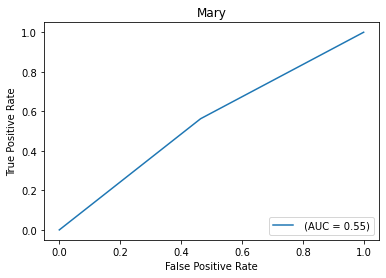

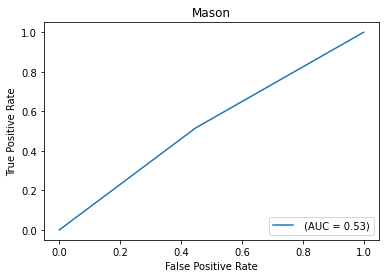

In [ ]:
def probability_baseline(person):
  y_pred = []
  if person == 'Mary':
    thresh = .44
  else:
    thresh = .56
  for i in range(60):
    val = np.random.rand(1)[0]
    if val <= thresh:
      y_pred.append(1)
    else:
      y_pred.append(0)
  return y_pred


  
mary_baseline = probability_baseline('Mary')
mason_baseline = probability_baseline('Mason')


def evaluate(ypred_mary, ytrue_mary, ypred_mason, ytrue_mason, show_plot):
  print(f'\n Mary: \n\t Precision: {precision_score(ypred_mary, ytrue_mary)} \n\t Recall: {recall_score(ypred_mary, ytrue_mary)} \n\t F-Score: {f1_score(ypred_mary, ytrue_mary)}  \n\n Mason: \n\t Precision: {precision_score(ypred_mason, ytrue_mason)} \n\t Recall: {recall_score(ypred_mason, ytrue_mason)} \n\t F-Score: {f1_score(ypred_mason, ytrue_mason)}\n ')
  mary_fpr, mary_tpr, mary_thresholds = roc_curve(ypred_mary, ytrue_mary)
  mason_fpr, mason_tpr, mason_thresholds = roc_curve(ypred_mason, ytrue_mason)
  mary_roc_auc = roc_auc_score(ypred_mary, ytrue_mary).round(2)
  mason_roc_auc =  roc_auc_score(ypred_mason, ytrue_mason).round(2)
  if show_plot == True:
    mary_curve = RocCurveDisplay(fpr=mary_fpr, tpr=mary_tpr, roc_auc=mary_roc_auc, estimator_name='')
    mary_curve.plot()
    plt.title('Mary')
    mason_curve = RocCurveDisplay(fpr=mason_fpr, tpr=mason_tpr, roc_auc=mason_roc_auc, estimator_name='')
    mason_curve.plot()
    plt.title('Mason')


  else:
    print("\n Mary ROC AUC: ", mary_roc_auc, "\n Mason ROC AUC:", mason_roc_auc)

evaluate(mary_baseline, test_labels['Mary_Like'], mason_baseline, test_labels['Mason_Like'], True)

We created a function called evaluate to determine how well a model performs compared to the ground truth labels. It takes in the predicted labels and the ground truth labels for both Mason and Mary and a fifth argument on whether it should display a graph and then calculates precision, recall, and f-score using the methods in sci-kit. Then, it calculates an ROC-AUC score, and either displays a graph or prints out the ROC-AUC score. As shown above, our baseline is slightly better at predicting whether we like a song than a coin flip.

We prepared the one hot encoded dataset for both the training set and the validation set first, and because we discovered later on that it preformed best, we also prepared the test set as well. We only needed to drop the genre column from the one hot encoded sets.

In [ ]:
one_hot_genre_t = songtrain.drop(columns = 'genre') 
one_hot_genre_v = songval.drop(columns = 'genre') 
one_hot_genre_te = songtest.drop(columns = 'genre')
one_hot_genre_t.head()

,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,popularity,country,dance,hip hop,metal,pop,r&b,rap,rock,soundtrack
198,2015,102,98,34,-3,12,15,251,1,22,27,0,0,0,1,0,0,0,0,0
273,2018,89,68,56,-8,12,32,174,56,32,77,0,0,0,0,1,0,0,0,0
269,2018,140,56,75,-8,11,46,221,55,11,79,0,0,0,0,0,0,1,0,0
240,2018,77,45,75,-9,55,36,199,3,11,82,0,0,1,0,0,0,0,0,0
56,2003,180,95,43,-4,51,77,195,0,9,31,0,0,0,1,0,0,0,0,0


To prepare the ordinally encoded data, we need to drop all columns that are genre-related except for genre itself.

In [ ]:
ordinal_genre_t = songtrain.drop(columns = ['dance', 'hip hop',	'pop', 'r&b',	'rap', 'rock', "country", "metal", "soundtrack"]) 
ordinal_genre_v = songval.drop(columns = ['dance', 'hip hop',	'pop', 'r&b',	'rap', 'rock', "country", "metal", "soundtrack"]) 
ordinal_genre_t.head()

,genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,popularity
198,3.0,2015,102,98,34,-3,12,15,251,1,22,27
273,4.0,2018,89,68,56,-8,12,32,174,56,32,77
269,6.0,2018,140,56,75,-8,11,46,221,55,11,79
240,2.0,2018,77,45,75,-9,55,36,199,3,11,82
56,3.0,2003,180,95,43,-4,51,77,195,0,9,31


##Random Forest Model

We started by training a random forest classifier on our dataset, as that was a recommendation made to us. To test this classifer, we need to train 4 different models - one for one hot encoded genres and one for ordinally encoded genres,  one set for Mary as well as one set for Mason. We decided to predict both training and validation labels for each model so that we could have an immediate comparison value in the ROC-AUC value for the validation set. 

In [ ]:
one_hot_mary_forest = RandomForestClassifier(n_estimators=350).fit(one_hot_genre_t, train_labels['Mary_Like'])
ypred_train_hot_mary = one_hot_mary_forest.predict(one_hot_genre_t)
ypred_val_hot_mary = one_hot_mary_forest.predict(one_hot_genre_v)

one_hot_mason_forest = RandomForestClassifier(n_estimators=350).fit(one_hot_genre_t, train_labels['Mason_Like'])
ypred_train_hot_mason = one_hot_mason_forest.predict(one_hot_genre_t)
ypred_val_hot_mason = one_hot_mason_forest.predict(one_hot_genre_v)


ordinal_mary_forest = RandomForestClassifier(n_estimators=350).fit(ordinal_genre_t,  train_labels['Mary_Like'])
ypred_train_ordinal_mary = ordinal_mary_forest.predict(ordinal_genre_t)
ypred_val_ordinal_mary= ordinal_mary_forest.predict(ordinal_genre_v)

ordinal_mason_forest = RandomForestClassifier(n_estimators=350).fit(ordinal_genre_t,  train_labels['Mason_Like'])
ypred_train_ordinal_mason= ordinal_mason_forest.predict(ordinal_genre_t)
ypred_val_ordinal_mason = ordinal_mason_forest.predict(ordinal_genre_v)

In [ ]:
print("ONE HOT FOREST TRAIN")
evaluate(ypred_train_hot_mary,train_labels['Mary_Like'], ypred_train_hot_mason, train_labels['Mason_Like'], False)
print("ONE HOT FOREST VAL")
evaluate(ypred_val_hot_mary,val_labels['Mary_Like'], ypred_val_hot_mason, val_labels['Mason_Like'], False)
print('\n\n')

print("ORDINAL FOREST TRAIN")
evaluate(ypred_train_ordinal_mary,train_labels['Mary_Like'], ypred_train_ordinal_mason, train_labels['Mason_Like'], False)
print("ORDINAL FOREST VAL")
evaluate(ypred_val_ordinal_mary,val_labels['Mary_Like'], ypred_val_ordinal_mason, val_labels['Mason_Like'], False)

ONE HOT FOREST TRAIN

 Mary: 
	 Precision: 1.0 
	 Recall: 1.0 
	 F-Score: 1.0  

 Mason: 
	 Precision: 1.0 
	 Recall: 1.0 
	 F-Score: 1.0
 

 Mary ROC AUC:  1.0 
 Mason ROC AUC: 1.0
ONE HOT FOREST VAL

 Mary: 
	 Precision: 0.5833333333333334 
	 Recall: 1.0 
	 F-Score: 0.7368421052631579  

 Mason: 
	 Precision: 1.0 
	 Recall: 0.7837837837837838 
	 F-Score: 0.8787878787878788
 

 Mary ROC AUC:  0.81 
 Mason ROC AUC: 0.89



ORDINAL FOREST TRAIN

 Mary: 
	 Precision: 1.0 
	 Recall: 1.0 
	 F-Score: 1.0  

 Mason: 
	 Precision: 1.0 
	 Recall: 1.0 
	 F-Score: 1.0
 

 Mary ROC AUC:  1.0 
 Mason ROC AUC: 1.0
ORDINAL FOREST VAL

 Mary: 
	 Precision: 0.5833333333333334 
	 Recall: 1.0 
	 F-Score: 0.7368421052631579  

 Mason: 
	 Precision: 0.9310344827586207 
	 Recall: 0.75 
	 F-Score: 0.8307692307692308
 

 Mary ROC AUC:  0.81 
 Mason ROC AUC: 0.83


Above is the report of all the statistics we calculated. For the sake of saving space, we did not print out a graph. We found this model performed best when n_estimators is set to 350. However, we see significant overfitting in the model, as the statistics for the test set are all reported as 1. This concerns us despite the ROC-AUC values, so we chose to test other models to see if we could find a better model that does not suffer from overfitting.

##Logistic Regression Model

Another model we tested was a logistic regression model provided by sci-kit. Similarly to the random forest classifier, we need 4 different models. After some tweaking, we found it performed best when allowed 2000 maximum iterations, and setting the class weight to balanced. 

In [ ]:
one_hot_mary_logreg = LogisticRegression(max_iter = 2000, class_weight = "balanced").fit(one_hot_genre_t, train_labels['Mary_Like'])
ypred_train_hot_mary = one_hot_mary_logreg.predict(one_hot_genre_t)
ypred_val_hot_mary = one_hot_mary_logreg.predict(one_hot_genre_v)

one_hot_mason_logreg = LogisticRegression(max_iter = 2000, class_weight = "balanced").fit(one_hot_genre_t, train_labels['Mason_Like'])
ypred_train_hot_mason = one_hot_mason_logreg.predict(one_hot_genre_t)
ypred_val_hot_mason = one_hot_mason_logreg.predict(one_hot_genre_v)


ordinal_mary_logreg = LogisticRegression(max_iter = 2000, class_weight = "balanced").fit(ordinal_genre_t,  train_labels['Mary_Like'])
ypred_train_ordinal_mary = ordinal_mary_logreg.predict(ordinal_genre_t)
ypred_val_ordinal_mary= ordinal_mary_logreg.predict(ordinal_genre_v)

ordinal_mason_logreg = LogisticRegression(max_iter = 2000, class_weight = "balanced").fit(ordinal_genre_t,  train_labels['Mason_Like'])
ypred_train_ordinal_mason= ordinal_mason_logreg.predict(ordinal_genre_t)
ypred_val_ordinal_mason = ordinal_mason_logreg.predict(ordinal_genre_v)


In [ ]:
print("ONE HOT LOGREG TRAIN")
evaluate(ypred_train_hot_mary,train_labels['Mary_Like'], ypred_train_hot_mason, train_labels['Mason_Like'], False)
print("ONE HOT LOGREG VAL")
evaluate(ypred_val_hot_mary,val_labels['Mary_Like'], ypred_val_hot_mason, val_labels['Mason_Like'], False)
print('\n\n')

print("ORDINAL LOGREG TRAIN")
evaluate(ypred_train_ordinal_mary,train_labels['Mary_Like'], ypred_train_ordinal_mason, train_labels['Mason_Like'], False)
print("ORDINAL LOGREG VAL")
evaluate(ypred_val_ordinal_mary,val_labels['Mary_Like'], ypred_val_ordinal_mason, val_labels['Mason_Like'], False)

ONE HOT LOGREG TRAIN

 Mary: 
	 Precision: 0.7076923076923077 
	 Recall: 0.6865671641791045 
	 F-Score: 0.696969696969697  

 Mason: 
	 Precision: 0.794392523364486 
	 Recall: 0.8252427184466019 
	 F-Score: 0.8095238095238095
 

 Mary ROC AUC:  0.76 
 Mason ROC AUC: 0.77
ONE HOT LOGREG VAL

 Mary: 
	 Precision: 0.6111111111111112 
	 Recall: 0.8461538461538461 
	 F-Score: 0.7096774193548387  

 Mason: 
	 Precision: 0.8275862068965517 
	 Recall: 0.75 
	 F-Score: 0.7868852459016394
 

 Mary ROC AUC:  0.72 
 Mason ROC AUC: 0.79



ORDINAL LOGREG TRAIN

 Mary: 
	 Precision: 0.7076923076923077 
	 Recall: 0.6571428571428571 
	 F-Score: 0.6814814814814816  

 Mason: 
	 Precision: 0.7757009345794392 
	 Recall: 0.7904761904761904 
	 F-Score: 0.7830188679245284
 

 Mary ROC AUC:  0.74 
 Mason ROC AUC: 0.74
ORDINAL LOGREG VAL

 Mary: 
	 Precision: 0.6944444444444444 
	 Recall: 0.8620689655172413 
	 F-Score: 0.7692307692307692  

 Mason: 
	 Precision: 0.7931034482758621 
	 Recall: 0.766666666666666

Once again, we decided to not print graphs to save on space. We found that the logistic regression model did not outperform the random forest classifier. 

##KNeighbors Model

The final model we decided to test out was a K neighbors classifier. Tweaking this model did not seem to change the results, so we did not change any parameters.

In [ ]:
one_hot_mary_kn = KNeighborsClassifier().fit(one_hot_genre_t, train_labels['Mary_Like'])
ypred_train_hot_mary = one_hot_mary_kn.predict(one_hot_genre_t)
ypred_val_hot_mary = one_hot_mary_kn.predict(one_hot_genre_v)

one_hot_mason_kn = KNeighborsClassifier().fit(one_hot_genre_t, train_labels['Mason_Like'])
ypred_train_hot_mason = one_hot_mason_kn.predict(one_hot_genre_t)
ypred_val_hot_mason = one_hot_mason_kn.predict(one_hot_genre_v)


ordinal_mary_kn = KNeighborsClassifier().fit(ordinal_genre_t,  train_labels['Mary_Like'])
ypred_train_ordinal_mary = ordinal_mary_kn.predict(ordinal_genre_t)
ypred_val_ordinal_mary= ordinal_mary_kn.predict(ordinal_genre_v)

ordinal_mason_kn = KNeighborsClassifier().fit(ordinal_genre_t,  train_labels['Mason_Like'])
ypred_train_ordinal_mason= ordinal_mason_kn.predict(ordinal_genre_t)
ypred_val_ordinal_mason = ordinal_mason_kn.predict(ordinal_genre_v)

In [ ]:
print("ONE HOT NEIGHBORS TRAIN")
evaluate(ypred_train_hot_mary,train_labels['Mary_Like'], ypred_train_hot_mason, train_labels['Mason_Like'], False)
print("ONE HOT NEIGHBORS VAL")
evaluate(ypred_val_hot_mary,val_labels['Mary_Like'], ypred_val_hot_mason, val_labels['Mason_Like'], False)
print('\n\n')

print("ORDINAL NEIGHBORS TRAIN")
evaluate(ypred_train_ordinal_mary,train_labels['Mary_Like'], ypred_train_ordinal_mason, train_labels['Mason_Like'], False)
print("ORDINAL NEIGHBORS VAL")
evaluate(ypred_val_ordinal_mary,val_labels['Mary_Like'], ypred_val_ordinal_mason, val_labels['Mason_Like'], False)

ONE HOT NEIGHBORS TRAIN

 Mary: 
	 Precision: 0.6615384615384615 
	 Recall: 0.7962962962962963 
	 F-Score: 0.7226890756302522  

 Mason: 
	 Precision: 0.8504672897196262 
	 Recall: 0.7777777777777778 
	 F-Score: 0.8125000000000001
 

 Mary ROC AUC:  0.81 
 Mason ROC AUC: 0.76
ONE HOT NEIGHBORS VAL

 Mary: 
	 Precision: 0.5833333333333334 
	 Recall: 0.84 
	 F-Score: 0.6885245901639344  

 Mason: 
	 Precision: 0.8620689655172413 
	 Recall: 0.6756756756756757 
	 F-Score: 0.7575757575757576
 

 Mary ROC AUC:  0.71 
 Mason ROC AUC: 0.75



ORDINAL NEIGHBORS TRAIN

 Mary: 
	 Precision: 0.6615384615384615 
	 Recall: 0.7962962962962963 
	 F-Score: 0.7226890756302522  

 Mason: 
	 Precision: 0.8411214953271028 
	 Recall: 0.7758620689655172 
	 F-Score: 0.8071748878923767
 

 Mary ROC AUC:  0.81 
 Mason ROC AUC: 0.76
ORDINAL NEIGHBORS VAL

 Mary: 
	 Precision: 0.5833333333333334 
	 Recall: 0.84 
	 F-Score: 0.6885245901639344  

 Mason: 
	 Precision: 0.8620689655172413 
	 Recall: 0.675675675675675

This model did not outperform the random forest classifier.

#Refined Model

We decided that we would use the random forest classifier despite it overfitting to the training data due to it outperforming the other models we tried. Below, we predict labels for the test data and evaluate those labels against the test ground truth labels.

ONE HOT Random Forest TEST

 Mary: 
	 Precision: 0.6451612903225806 
	 Recall: 1.0 
	 F-Score: 0.7843137254901961  

 Mason: 
	 Precision: 0.8620689655172413 
	 Recall: 0.78125 
	 F-Score: 0.8196721311475409
 


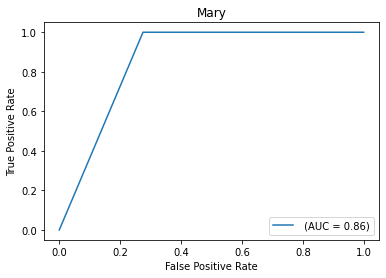

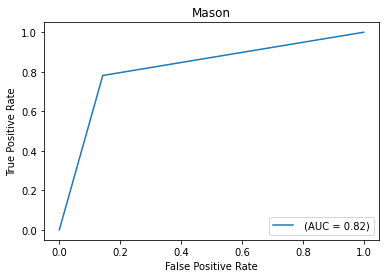

In [ ]:
ypred_test_hot_mary = one_hot_mary_forest.predict(one_hot_genre_te)
ypred_test_hot_mason = one_hot_mason_forest.predict(one_hot_genre_te)
print("ONE HOT Random Forest TEST")
evaluate(ypred_test_hot_mary,test_labels['Mary_Like'], ypred_test_hot_mason, test_labels['Mason_Like'], True)

From the results above, we can determine that the model correctly predicts the label for Mary 86% of the time, and correctly predicts the label for Mason 82% of the time. We believe that these results are satisfactory, as the model outperforms other models investigated, and significantly outperforms our baseline.